In [45]:
!pip install gensim
import pandas as pd
import numpy as np
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:
df = pd.read_excel('MACDONALDS_FINAL_BALANCED_DATA.xlsx')
# Dataset was loaded locally during development.
# File upload code removed for clean presentation.

In [13]:
df.head(5)

,review,label
0,Making customers wait for more than half and h...,negative
1,I visited the McDonald’s Jogeshwari outlet yes...,negative
2,Pathetic system..ordered on mcdelievry app.. e...,negative
3,Service was very late… they were doing Timepas...,negative
4,Worst McDonald's takes alot to prepare the ord...,negative


In [14]:
print(df.shape)
print(df.dtypes)

(486, 2)
review    object
label     object
dtype: object


In [15]:
df['label'].value_counts()

,count
label,
negative,243
positive,243


In [40]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
negations = {'not', 'no', 'nor', 'never', "n't"}
stop_words = stop_words - negations

def preprocess_review(review):
    # convert to lowercase
    review = review.lower()

    # remove punctuation and numbers
    #This removes everything from the review except lowercase letters and spaces.
    review = re.sub(r'[^a-z\s]', '', review)

    # split into words
    words = review.split()

    # remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

In [41]:
df['clean_review'] = df['review'].astype(str).apply(preprocess_review)

In [42]:
def sentence_vector(sentence, model):
    # split the sentence into individual words
    words = sentence.split()

    # get Word2Vec vectors only for words known to the model
    vectors = [model.wv[word] for word in words if word in model.wv]

    # if no word has a vector, return a zero vector
    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    # take the average of all word vectors to represent the sentence
    return np.mean(vectors, axis=0)

This function turns a sentence into numbers by averaging the Word2Vec vectors of its words.

In [43]:
w2v_model = Word2Vec(
    sentences=sentences,   # uses tokenized reviews to learn word relationships
    vector_size=100,       # sets the size of each word embedding vector
    window=5,              # considers 5 surrounding words as context
    min_count=2,           # ignores words that appear less than 2 times
    workers=4              # uses 4 CPU cores to speed up training
)

In [44]:
x = np.array([
    sentence_vector(text, w2v_model)
    for text in df['review']
])

y = df['label']

convert each review into a Word2Vec sentence vector

target labels for sentiment classification

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,
                                               random_state=42,stratify=y)

stratify=y Ensures train and test sets keep the same positive/negative class ratio as the original dataset.

In [28]:
logistic=LogisticRegression(max_iter=1000)
logistic.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

In [30]:
y_pred=logistic.predict(x_test)

max_iter=1000 Sets enough iterations for Logistic Regression to fully converge and avoid early stopping errors.

In [31]:
acc_logistic=accuracy_score(y_test,y_pred)*100
print('Accuracy:',acc_logistic)

Accuracy: 66.3265306122449


In [32]:
confusion=confusion_matrix(y_test,y_pred)
print('Confusion Matrix:',confusion)

Confusion Matrix: [[32 17]
 [16 33]]


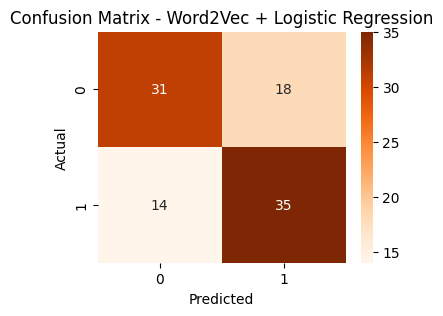

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = [[31, 18],
      [14, 35]]

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Word2Vec + Logistic Regression")
plt.show()

In [35]:
from sklearn.model_selection import cross_val_score

scores=cross_val_score(logistic,x,y,cv=5)
print(scores)
print('mean accuracy:',scores.mean())

[0.71428571 0.49484536 0.59793814 0.69072165 0.63917526]
mean accuracy: 0.6273932253313697


In [36]:
def predict_review(review_text, w2v_model, logistic_model):
    # preprocess input review
    clean_text = preprocess_review(review_text)

    # convert review to Word2Vec vector
    review_vector = sentence_vector(clean_text, w2v_model)

    # reshape for prediction
    review_vector = [review_vector]

    # predict label and confidence
    prediction = logistic_model.predict(review_vector)[0]
    probability = logistic_model.predict_proba(review_vector).max()

    return prediction, probability

In [37]:
confusing_reviews = [
    "The product looks good but the quality is not great.",
    "It is okay, not bad but not very impressive either.",
    "I didn’t expect much, but it’s not terrible.",
    "Great job, it stopped working on the first day.",
    "If the price was lower, this would have been a good product.",
    "Customer support was helpful but the product itself is disappointing.",
    "It works, nothing special.",
    "Initially it seemed fine, later it turned out to be a bad decision."
]

In [38]:
for review in confusing_reviews:
  label,prob=predict_review(review, w2v_model,logistic)
  print('\nReview:',review)
  print('prediction:',label)
  print('confidence:',round(prob*100,2),'%')


Review: The product looks good but the quality is not great.
prediction: positive
confidence: 50.46 %

Review: It is okay, not bad but not very impressive either.
prediction: positive
confidence: 50.33 %

Review: I didn’t expect much, but it’s not terrible.
prediction: positive
confidence: 50.02 %

Review: Great job, it stopped working on the first day.
prediction: negative
confidence: 50.5 %

Review: If the price was lower, this would have been a good product.
prediction: negative
confidence: 50.22 %

Review: Customer support was helpful but the product itself is disappointing.
prediction: negative
confidence: 50.14 %

Review: It works, nothing special.
prediction: negative
confidence: 50.72 %

Review: Initially it seemed fine, later it turned out to be a bad decision.
prediction: negative
confidence: 50.92 %


The model performs very well on clear sentiments but struggles on mixed or neutral reviews, which is a known limitation of bag-of-words based approaches.